<h1 align="center">Reduce Stage</h1>

# Goal

Predict the total reduce stage duration based on the amount of workers, tasks and their durations.

# Strong-Scaling Experiment

Find below some information about the experiment whose logs are analysed in this work.

In [1]:
# Notebook configuration, modules import, functions

# plots in the notebook
%matplotlib inline

# Make graphs more readable
import matplotlib
matplotlib.rcParams.update({'font.size': 16,
                            'font.family': 'serif',
                            'lines.linewidth': 2})
from common import *
  
# f_mean has one value per worker amount and is ordered by worker amount
def calc_r2_f_mean(f_mean, xs=None, ys=None):
    if not xs:
        xs = stage_workers
    if not ys:
        ys = stage_durations
    def r2_f(x): return f_mean[worker_amounts.index(x)]
    return calc_r2_fn(xs, ys, r2_f)

def get_experiment_info(file_size, apps, worker_amounts):
    block_size = 128 * 1024 * 1024
    n_blocks = int(file_size/block_size + 0.5)
    n_tasks = set([len(app.stages[1].tasks) for app in apps])
    assert len(n_tasks) == 1  # All executions have the same number of tasks
    n_tasks = n_tasks.pop()

    info = '* Input size: {:.1f} GB\n'.format(file_size/1024**3)
    info += '* Input blocks (128 MB each): {:d}\n'.format(n_blocks)
    info += '* Reduce tasks: {:d}\n'.format(n_tasks)
    info += '* Worker amounts: {}\n'.format(', '.join((str(w) for w in worker_amounts)))
    info += '* Executions: {:d} ({:g} for each worker amount)\n'.format(len(apps), len(apps)/len(worker_amounts))
    info += '* Total reduce tasks: {:d} x {:d} = {:d}'.format(len(apps), n_tasks, len(apps) * n_tasks)
    
    return info, n_tasks

In [2]:
# Load experiment data
apps, worker_amounts = parse_strong_scaling(map_outliers=True)

In [3]:
# Some experiment information
info, n_tasks = get_experiment_info(48542876756, apps, worker_amounts)
Markdown(info)

* Input size: 45.2 GB
* Input blocks (128 MB each): 362
* Reduce tasks: 200
* Worker amounts: 4, 8, 16, 32, 64
* Executions: 145 (29 for each worker amount)
* Total reduce tasks: 145 x 200 = 29000

The amount of tasks can be set manually and its default value is the number of RDD partitions. Both strong- and weak-scaling experiments used the same default amount of reduce tasks.

## Reduce stage durations
The figure below shows the reduce stage durations that we want to predict, from all the executions. The line that connects their means will be used in other figures to compare with different models.

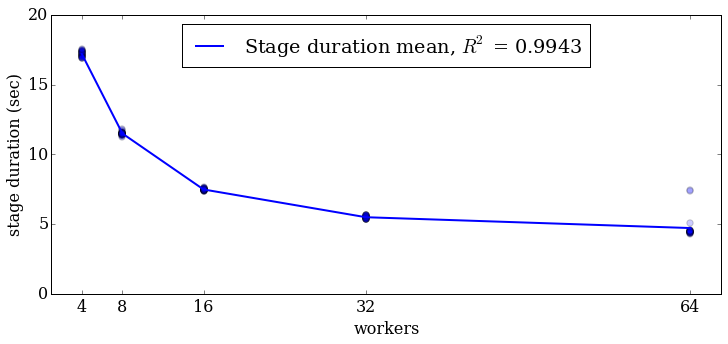

Reduce stage durations and their means per worker amount.

In [4]:
# Mean of stage durations per worker amount

plt.subplots(figsize=(12,5))

# Scatter plot with all map durations
stage_durations = np.array([a.stages[1].duration for a in apps])
stage_durations = stage_durations / 1000
stage_workers = [app.workers for app in apps]
plt.scatter(stage_workers, stage_durations, alpha=0.2, s=40)
plt.xticks(worker_amounts)
plt_setup('workers', 'stage duration (sec)')

# Line with the mean map duration for each worker amount
# Means per worker amount
stage_means = []
for workers in worker_amounts:
    _apps = (a for a in apps if a.workers == workers)
    _ys = [app.stages[1].duration for app in _apps]
    stage_means.append(np.mean(_ys)/1000)

# r-squared
r2 = calc_r2_f_mean(stage_means)

stage_label = get_r2_label('Stage duration mean', r2)
plt.plot(worker_amounts, stage_means, label=stage_label)

plt.legend(loc='upper center')
plt.show()
Markdown('Reduce stage durations and their means per worker amount.')

# Mean model

The mean model uses the mean of all tasks to predict the stage durations. In this approach, we first calculate the mean duration of all tasks (~30k tasks) and then its value is multiplied by the number of tasks per worker.

The tasks are distributed evenly across all the nodes and, if some worker executes more tasks than other, we consider the highest amount of tasks. In this experiment, each worker has 2 threads. The total map duration is calculated by the function below.

In [5]:
# total time = (highest) number of tasks per worker x task time mean

def mean_model(workers, tasks, mean):
    threads = 2 * workers
    return np.ceil(tasks/threads) * mean

In [6]:
tasks_durations = np.array([t.duration for a in apps for t in a.stages[1].tasks])/1000

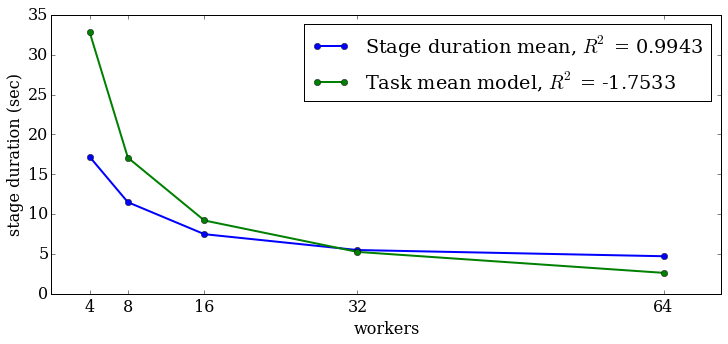

Comparison between the average of stage durations and the model based on the mean of all tasks.

In [7]:
# Plot stage mean and mean model results

plt.subplots(figsize=(12,5))

plt.plot(worker_amounts, stage_means, '-o', label=stage_label)

# Using the mean model
def model(x): return mean_model(x, n_tasks, tasks_durations.mean())
mean_model_ys = [model(x) for x in worker_amounts]
r2 = calc_r2_f_mean(mean_model_ys)
mean_model_label = get_r2_label('Task mean model', r2)
plt.plot(worker_amounts, mean_model_ys, '-o', label=mean_model_label)

plt_setup('workers', 'stage duration (sec)')
plt.xticks(worker_amounts)
plt.legend()
plt.show()

Markdown(
    'Comparison between the average of stage durations and the model based on the mean of all tasks.'
)

In the figure above, the task mean model reduce time for 4 workers is about two times larger than the measured stage mean. With 32 workers, the values seems to be the same and with 64, the model value is about two times lower.

# Task duration distribution
To improve the model, we should understand the stage task duration distribution.

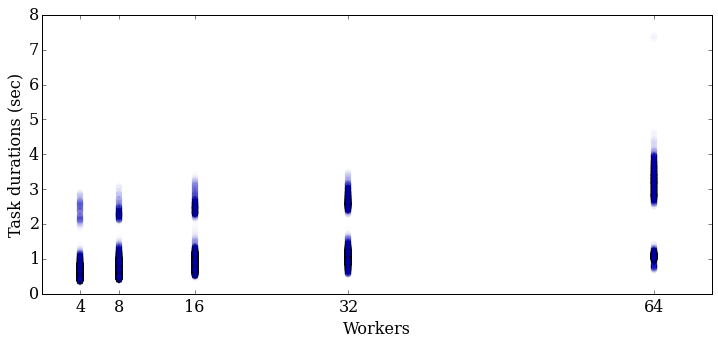

Duration of all tasks from all executions grouped by worker amount.

In [8]:
# Tasks' durations

tasks_workers = []
[tasks_workers.extend([a.workers] * len(a.stages[1].tasks)) for a in apps];

plt.subplots(figsize=(12,5))
plt.scatter(tasks_workers, tasks_durations, alpha=0.01, s=40)
plt.xticks(worker_amounts)
plt_setup('Workers', 'Task durations (sec)')
plt.show()

Markdown(
    'Duration of all tasks from all executions grouped by worker amount.'
)

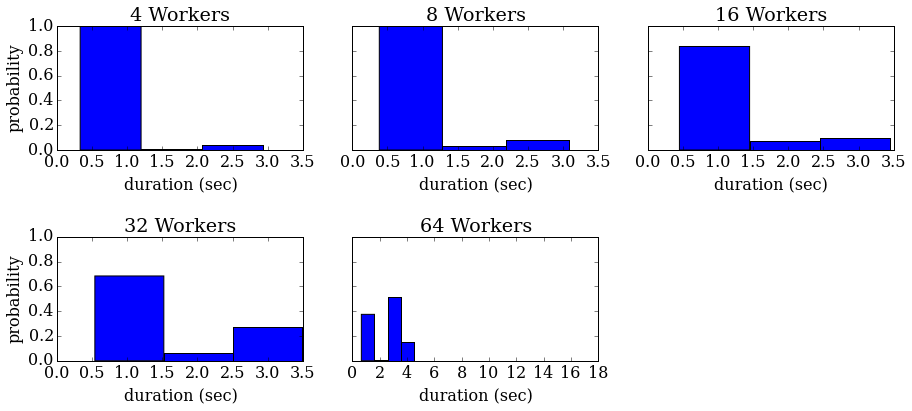

Histograms of task durations per worker amount.

In [9]:
# Plot task duration histogram per worker amount

fig, axs = plt.subplots(2, 3, figsize=(15,6), sharey=True)
axs[-1, -1].axis('off')
fig.subplots_adjust(hspace=0.7)

for n, workers in enumerate(worker_amounts):
    ax = axs[int(n/3)][n%3]
    _apps = (a for a in apps if a.workers == workers)
    durations = np.array([t.duration for a in _apps for t in a.stages[1].tasks])/1000
    bins = max(durations) - min(durations) + 1
    ax.hist(durations, bins, normed=True)
    ax.set_xlabel('duration (sec)')
    ax.set_ylim(0, 1)
    xmax = 18 if workers == 64 else 3.5
    ax.set_xlim(0, xmax)
    ax.set_title('{:d} Workers'.format(workers))
    if n == 0 or n == 3:
        ax.set_ylabel('probability')
plt.show()

Markdown(
    'Histograms of task durations per worker amount.'
)

In the histograms above, a second curve around 2 seconds becomes more evident as the number of workers increases. In the next section, we investigate the tasks belonging to each group.

## Longer tasks

We now analyse the task duration taking into consideration when they are launched. The time is zero when the first task starts.

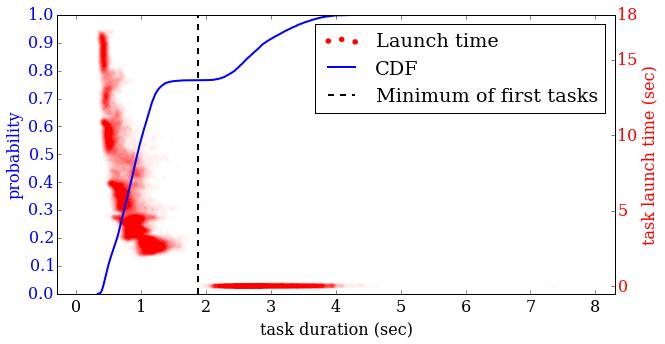

Task duration cumulative distribution function.

In [10]:
# Plot tasks' durations, CDF and a threshold for first tasks

_, ax1 = plt.subplots(figsize=(10,5))

# Dashed line with a threshold for the task durations
dur_thr = min((t.duration for a in apps for t in a.stages[1].tasks[:2*a.workers]))/1000
plot = ax1.axvline(dur_thr, ls='--', color='k', label='Minimum of first tasks')
plots = [plot]

# Collecting tasks launch and duration time
launchXdurs = []
for app in apps:
    tasks = app.stages[1].tasks
    first_start = min((t.start for t in tasks))
    launchXdurs.extend([{
        'launch': (t.start - first_start)/1000,
        'duration': t.duration/1000}
         for t in tasks])

# Launch time scatter plot
_xs = [ld['duration'] for ld in launchXdurs]
_ys = [ld['launch'] for ld in launchXdurs]
ax1.scatter(_xs, _ys, alpha=0.01, color='r')
ax1.set_ylabel('task launch time (sec)', color='r')
max_ys = int(np.ceil(max(_ys)))
ax1.set_ylim(-0.5, max_ys)
ax1.set_yticks([0, 5, 10, 15] + [max_ys])
# scatter legend with higher alpha
plot = ax1.scatter([], [], color='r', label='Launch time')
plots.append(plot)

# Counting the occurencies (_ys) of duration values (_xs)
launchXdurs.sort(key=lambda ld: ld['duration'])
_xs = [launchXdurs[0]['duration']]
count = [1]
for launchXdur in launchXdurs[1:]:
    duration = launchXdur['duration']
    if duration == _xs[-1]:
        count[-1] += 1
    else:
        _xs.append(duration)
        count.append(1)
_ys = np.array(count)
_ys = _ys/_ys.sum()

# CDF plot
ax2 = ax1.twinx()
plot, = ax2.plot(_xs, _ys.cumsum(), linewidth=2, label='CDF')
plots.append(plot)
ax2.set_ylabel('probability', color='b')
ax2.set_ylim(0, 1)
ax2.set_yticks(np.linspace(0, 1, 11))

# Common x-axis
max_xs = int(np.ceil(max(_xs)))
ax1.set_xlabel('task duration (sec)')
ax2.set_xticks(list(range(0, max_xs + 1, 1)))
ax2.set_xlim(-0.3, max_xs + 0.3)

# Inverting y-axes for readability
# right y-axis
ax1.spines['right'].set_visible(True)
ax1.yaxis.set_label_position('right')
ax1.yaxis.set_ticks_position('right')
[tl.set_color('r') for tl in ax1.get_yticklabels()]
# left y-axis
ax2.spines['left'].set_visible(True)
ax2.yaxis.set_label_position('left')
ax2.yaxis.set_ticks_position('left')
[tl.set_color('b') for tl in ax2.get_yticklabels()]

plots = [plots[1], plots[2], plots[0]]
plt.legend(plots, [p.get_label() for p in plots])
plt.show()

Markdown(
    "Task duration cumulative distribution function."
)

In the figure above, each task is a red point located at *(duration, launch time)*. The launch time zero is the start time of the first task to be executed. The solid line is the tasks' duration cumulative ditribution function. The vertical dashed line is the fastest execution of the first task run in each thread.

The CDF plateau around 75% separates faster tasks from the slower ones. The dashed line with the fastest execution of the first tasks suggests that they are the slowest ones. To make sure the slowest ones are the first to be excuted, we can check if any task finishes before the first ones are launched.

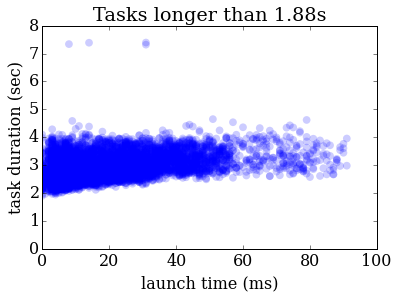

Longer tasks and their launch time. The duration threshold is the fastest execution of the first tasks run in each worker thread. Total tasks: 6800, non-first tasks (removed from the figure): 1.

In [11]:
# Scatter plot with longer tasks that are the first ones

n_longer, n_first = 0, 0
for app in apps:
    max_index = 2*app.workers - 1
    longer = [t for t in app.stages[1].tasks if t.duration > dur_thr * 1000]
    n_longer += len(longer)
    first = [t for t in longer if t.index <= max_index]
    n_first += len(first)
    _ys = [t.duration/1000 for t in first]
    _xs = np.array([t.start for t in first])
    _xs = (_xs - min(_xs))
    plt.scatter(_xs, _ys, alpha=0.2, s=60, edgecolors='none')

plt.xlim(xmin=-0.01)
plt_setup('launch time (ms)', 'task duration (sec)')
plt.title('Tasks longer than {:.2f}s'.format(dur_thr))
plt.show()

Markdown(
    'Longer tasks and their launch time. The duration threshold is the fastest execution of the first tasks'
    ' run in each worker thread. Total tasks: {:d}, non-first tasks (removed from the figure): {:d}.'.format(
    n_longer, n_longer - n_first)
)

In [12]:
# Fastest task duration, in milliseconds
min((t.duration for a in apps for t in a.stages[1].tasks))

332

From the Figure above, all the longer tasks (except 1) are launched before 140ms. As the fastest stage task finishes in 332ms, we can conclude that the slowest tasks are the first ones to be scheduled. With that in mind, we propose another model discussed below.

# Two-mean model

Based on the distribution of the task durations, we evaluate a model with based on two means: one for the first tasks to be executed in each thread and another for all the other tasks. The total map duration time includes the higher mean value to process the first tasks in parallel. More time is added using the remaining tasks and the lower mean as in the previous model.

In [13]:
def two_mean_model(workers, tasks, high_mean, low_mean):
    """
      workers: amount of workers
        tasks: number of tasks
    high_mean: mean duration of the first tasks
     low_mean: mean duration of the remaining tasks
    """
    total_time = high_mean  # all the workers process their first task
    threads = 2 * workers
    total_time += mean_model(workers, tasks - threads, low_mean)
    return total_time

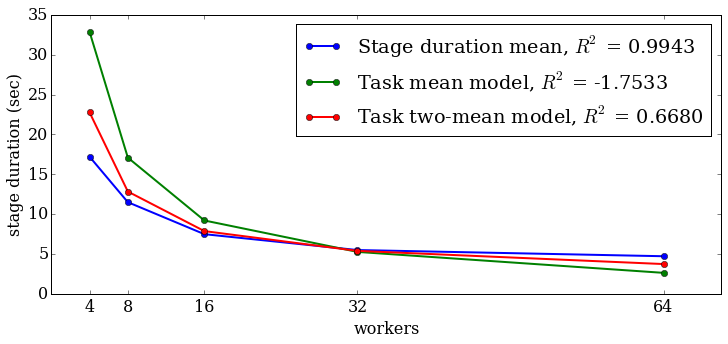

Stage duration mean and both models with one and two mean values.

In [14]:
# Plot stage mean, task mean model and two-mean model

def get_two_mean_durations(apps):
    slow_tasks, fast_tasks = [], []
    for a in apps:
        threads = 2*a.workers
        slow_tasks.extend([t.duration for t in a.stages[1].tasks[:threads]])
        fast_tasks.extend([t.duration for t in a.stages[1].tasks[threads:]])
    low = np.mean(fast_tasks) / 1000
    high = np.mean(slow_tasks) / 1000
    
    def model(x):
        return two_mean_model(x, n_tasks, high, low)
    
    return [model(x) for x in worker_amounts]

plt.subplots(figsize=(12,5))

plt.plot(worker_amounts, stage_means, '-o', label=stage_label)
plt.plot(worker_amounts, mean_model_ys, '-o', label=mean_model_label)

# Two-mean model
two_mean_ys = get_two_mean_durations(apps)
r2 = calc_r2_f_mean(two_mean_ys)
two_mean_label = get_r2_label('Task two-mean model', r2)
plt.plot(worker_amounts, two_mean_ys, '-o', label=two_mean_label)

plt_setup('workers', 'stage duration (sec)')
plt.xticks(worker_amounts)
plt.legend()
plt.show()

Markdown('Stage duration mean and both models with one and two mean values.')

In the figure above, The two-mean model is better than the previous one, but its low r-squared value must be improved. Issues discussed about the previous model are still present, though in a smaller proportion. The results suggests that the mean of all tasks can only represent well the 32-worker scenario. To improve the model, we analyse the different tasks' duration means per worker amount in the next section.

## Profiling phase

In [15]:
# Parsing experiment logs
apps_weak, worker_amounts_weak = parse_weak_scaling()

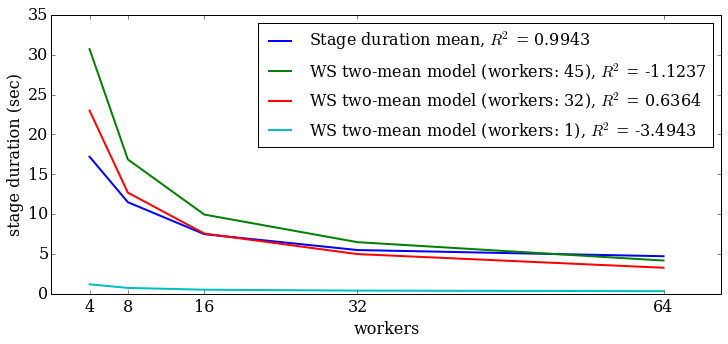

Stage mean and its prediction using the two-mean model and weak-scaling experiments.

In [16]:
# Prediction from the weak-scaling experiment using two-mean model

plt.subplots(figsize=(12,5))

plt.plot(worker_amounts, stage_means, label=stage_label)

def plot_two_mean_weak(worker_amount):
    # Two-mean model
    ys = get_two_mean_durations((a for a in apps_weak if a.workers == worker_amount))
    r2 = calc_r2_f_mean(ys)
    label = 'WS two-mean model (workers: {:d}), '.format(worker_amount) + r'$R^{2}$' \
        + ' = {:.4f}'.format(r2)
    plt.plot(worker_amounts, ys, label=label)
    
plot_two_mean_weak(45)
plot_two_mean_weak(32)
plot_two_mean_weak(1)

plt_setup('workers', 'stage duration (sec)')
plt.xticks(worker_amounts)
plt.legend(fontsize=16)
plt.show()

Markdown(
    'Stage mean and its prediction using the two-mean model and weak-scaling experiments.'
)

# Linear-mean model

To understand how the task duration varies according to the number of workers, we separate the tasks in three groups: first tasks (slower), non-first tasks (faster) and all tasks.

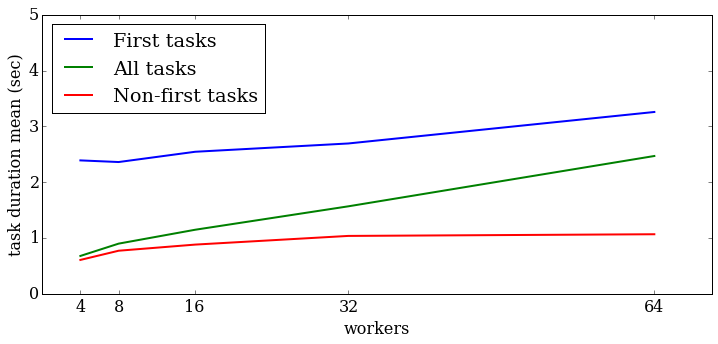

First, all and non-first tasks' duration means per worker.

In [17]:
# Plot task duration means

plt.subplots(figsize=(12,5))

def calc_tasks_by_workers(select_fn, reduce_fn):
    ys = []
    for workers in worker_amounts:
        tasks = []
        [tasks.extend(select_fn(a)) for a in apps if a.workers == workers]
        ys.append(reduce_fn(tasks))
    return ys

def calc_tasks_mean(tasks): return np.mean([t.duration for t in tasks])/1000

ys = calc_tasks_by_workers(lambda a: a.stages[1].tasks[:2*a.workers], calc_tasks_mean)
plt.plot(worker_amounts, ys, label='First tasks')

tasks_means = calc_tasks_by_workers(lambda a: a.stages[1].tasks, calc_tasks_mean)
plt.plot(worker_amounts, tasks_means, label='All tasks')

ys = calc_tasks_by_workers(lambda a: a.stages[1].tasks[2*a.workers:], calc_tasks_mean)
plt.plot(worker_amounts, ys, label='Non-first tasks')

plt_setup('workers', 'task duration mean (sec)')
plt.ylim(0, 5)
plt.xticks(worker_amounts)
plt.legend(loc=0)
plt.show()

Markdown("First, all and non-first tasks' duration means per worker.")

In the figure above, the first tasks' mean durations decreases from 4 to 8 workers. However, the value increases in the remaining worker amounts. For this reason, we will continue by analysing the mean of all tasks instead of separating the slower from the fastest ones.

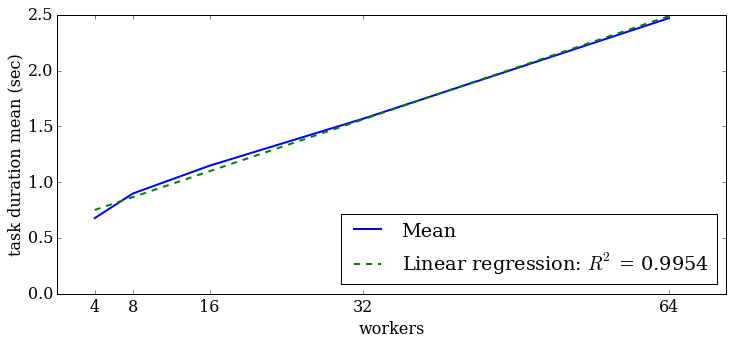

Reduce task duration means and its regression $y = 0.029x + 0.636$.

In [18]:
# Linear regression of all tasks' mean

plt.subplots(figsize=(12,5))

plt.plot(worker_amounts, tasks_means, label='Mean')

slope, intercept, r_value, p_value, std_err = stats.linregress(tasks_workers, tasks_durations)
def linreg(x): return slope*x + intercept
ys = [linreg(x) for x in worker_amounts]
r2 = calc_r2(worker_amounts, tasks_means, ys)
label = 'Linear regression' + r': $R^{2}$' + ' = {:.4f}'.format(r2)
plt.plot(worker_amounts, ys, '--', label=label)

plt_setup('workers', 'task duration mean (sec)')
plt.xticks(worker_amounts)
plt.legend(loc=0)
plt.show()

Markdown('Reduce task duration means and its regression ' + r'$y = {:.3f}x + {:.3f}$.'.format(slope, intercept))

By the figure above, the tasks' duration mean are well approximated by its linear regression. We now use this regression for a new model that uses the number of workers to calculate the mean value and then uses the mean model to calculate the total duration time:

In [19]:
def linear_mean_model(slope, intercept, workers, tasks):
    mean = slope * workers + intercept
    return mean_model(workers, tasks, mean)

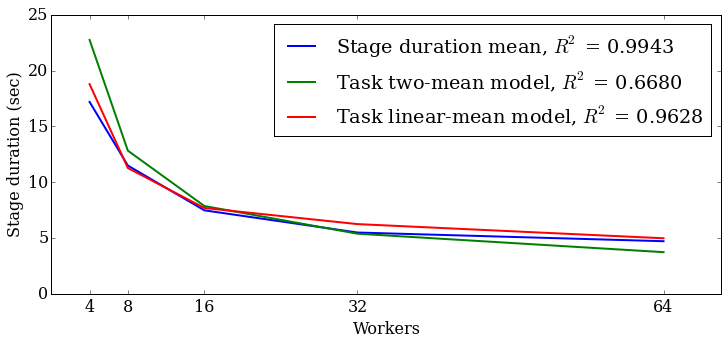

In [20]:
# Task two-mean and linear-mean model comparison

plt.subplots(figsize=(12,5))

plt.plot(worker_amounts, stage_means, label=stage_label)

# Using the linear-mean model
slope, intercept, r_value, p_value, std_err = stats.linregress(tasks_workers, tasks_durations)
def model(x): return linear_mean_model(slope, intercept, x, n_tasks)
linear_mean_ys = [model(x) for x in worker_amounts]
r2 = calc_r2_f_mean(linear_mean_ys)
linear_mean_label = 'Task linear-mean model, ' + r'$R^{2}$' + ' = {:.4f}'.format(r2)

plt.plot(worker_amounts, two_mean_ys, label=two_mean_label)
plt.plot(worker_amounts, linear_mean_ys, label=linear_mean_label)

plt_setup('Workers', 'Stage duration (sec)')
plt.xticks(worker_amounts)
plt.legend()
plt.show()

## Profiling phase

Overview:
1. Using only 1 worker, run the application with 1, 2, 4 and 8 blocks (1 block has 128MB);
1. With the result from step 1, predict the whole data stage duration with only one VM;
1. Conduct a small strong-scale experiment, with reduced data and worker amounts;
1. With results from previous step, predict the whole data stage duration with different worker amounts.

### 1-worker

* HDFS input data sizes:
  * 128 MB
  * 256 MB
  * 512 MB
  * 1 GB
* Repetitions: 10

In [21]:
# Reading input data

input_sizes_1vm = (134217465, 268425644, 536816741, 1073741798)
input_sizes_1vm_labels = (128, 256, 512, 1024)
repetitions_1vm = 10
apps_1vm, worker_amounts_1vm = parse('one_vm_data/app-*')
apps_1vm, worker_amounts_1vm = tuple(apps_1vm), tuple(worker_amounts_1vm)

# Making sure there's only one 1 worker and all repetitions are done
assert(worker_amounts_1vm == (1,))
assert(len(apps_1vm) == len(input_sizes_1vm) * repetitions_1vm)

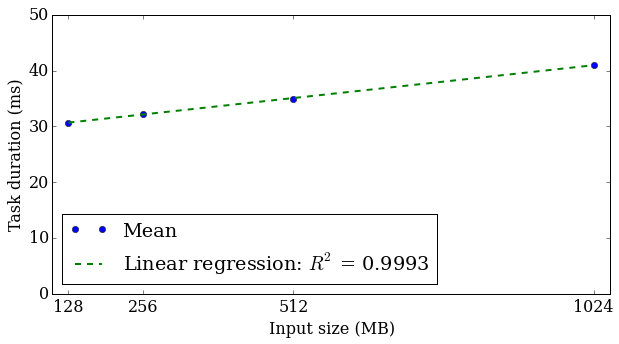

According to this regression, the task duration mean for the whole input in one worker would be 561 ms.

In [22]:
# Task duration

def plot_task_dur_with_regr(xs, durations, xlabel):
    plt.subplots(figsize=(10,5))
    
    means = [np.mean(dur) for dur in durations.values()]
    plt.plot(xs, means, 'o', label='Mean')
    plt_setup(xlabel, 'Task duration (ms)')
    plt.xticks(xs)
    
    # Regression
    all_sizes, all_durs = [], []
    for size, durs in durations.items():
        all_sizes.extend([size] * len(durs))
        all_durs.extend(durs)
    slope, intercept, r_value, p_value, std_err = stats.linregress(all_sizes, all_durs)
    def lin_reg(x): return slope*x + intercept
    ys_regr = [lin_reg(x) for x in xs]
    r2 = calc_r2(xs, means, ys_regr)
    label = 'Linear regression' + r': $R^{2}$' + ' = {:.4f}'.format(r2)
    plt.plot(xs, ys_regr, '--', label=label)
    plt.legend(loc=0)
    
    return lin_reg, slope

_durations = {size:[] for size in input_sizes_1vm}
for size in input_sizes_1vm:
    first_app = input_sizes_1vm.index(size) * repetitions_1vm
    last_app = first_app + repetitions_1vm - 1
    _apps = apps_1vm[first_app:last_app + 1]
    _durations[size].extend(t.duration for a in _apps for t in a.stages[1].tasks)
    
lin_reg, _ = plot_task_dur_with_regr(input_sizes_1vm, _durations, 'Input size (MB)')
plt.xticks(input_sizes_1vm, input_sizes_1vm_labels)
plt.ylim(0, 50)
plt.xlim(100*1024**2, 1052*1024**2)
plt.show()

total_input = 48542876756
prediction_1vm = lin_reg(total_input)

Markdown('According to this regression, the task duration mean for the whole input in one worker '
         'would be {:.0f} ms.'.format(prediction_1vm))

### Small strong-scaling experiment

1 GB with 1 and 2 workers.

In [23]:
apps_sss, worker_amounts_sss = parse_sss(workers=[1, 2])

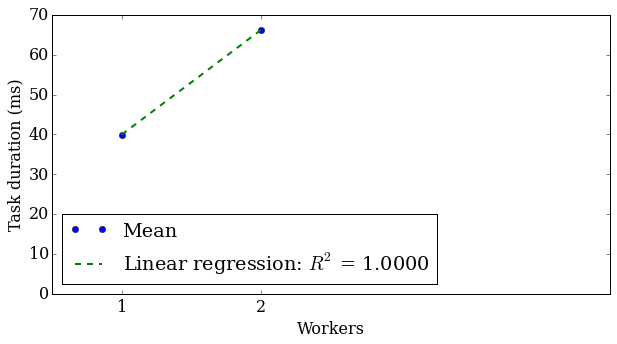

If the input data is constant, the task duration mean increases as we add workers.

In [24]:
_apps, _was = apps_sss, worker_amounts_sss
_durations = {wa: [] for wa in _was}
[_durations[a.workers].extend(t.duration for t in a.stages[1].tasks) for a in _apps]
_, slope = plot_task_dur_with_regr(_was, _durations, 'Workers')
plt.xlim(0.5, 4.5)
plt.show()

Markdown('If the input data is constant, the task duration mean increases as we add workers.')

Now, we combine both results by using the regression above and adjusting its _intercept_ value with the prediction of the 1-VM experiment. Then, we have the following prediction:

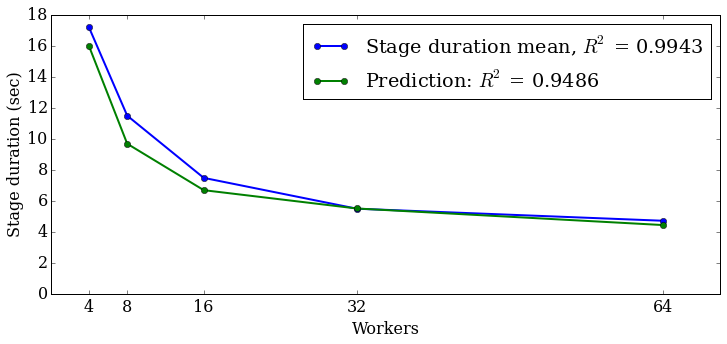

Stage duration predicted with task duration mean = $26.3055x + 534.2397$ ms, where $x$ is the amount of           workers.

In [25]:
plt.subplots(figsize=(12,5))

plt.plot(worker_amounts, stage_means, '-o', label=stage_label)

intercept = prediction_1vm - slope
def model(x): return linear_mean_model(slope, intercept, x, 200)

_ys = [model(worker)/1000 for worker in worker_amounts]
r2 = calc_r2(worker_amounts, stage_means, _ys)
label = 'Prediction' + r': $R^{2}$' + ' = {:.4f}'.format(r2)
plt.plot(worker_amounts, _ys, '-o', label=label)
plt_setup('Workers', 'Stage duration (sec)')
plt.xticks(worker_amounts)
plt.legend()
plt.show()

Markdown('Stage duration predicted with task duration mean = ${:.4f}x + {:.4f}$ ms, where $x$ is the amount of \
          workers.'.format(slope, intercept))

# Conclusion

The current model has a good accuracy by using only 2 workers and 1 GB of data. 

# Miscellaneous
Some observations and assumption checkings.

## Task details
Spark logs provide us some details about each task:

* Computation time
* Scheduler delay
* GC time (JVM)
* Time spent waiting for I/O
* Task deserialization time
* Result serialization time

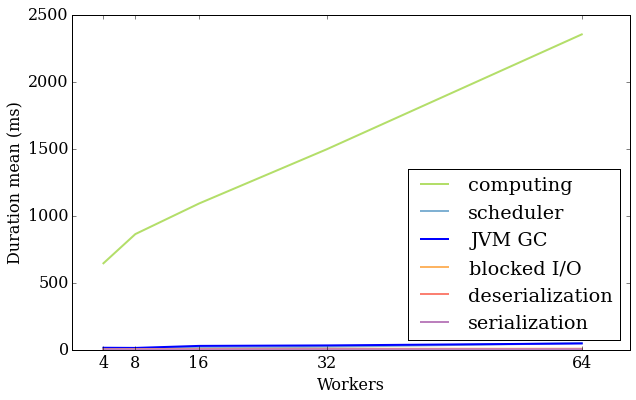

As we can notice in the figure above, the computing time is the bottleneck.

In [26]:
# Plot task duration details.

def init_dict(label, color=None):
    info = {'means': [], 'kwargs': {'label': label}}
    if color:
        info['kwargs']['color'] = color
    return info
data = {
    'gc': init_dict('JVM GC'),
    'serial': init_dict('serialization', '#bc80bd'),
    'deserial': init_dict('deserialization', '#fb8072'),
    'comp': init_dict('computing', '#b3de69'),
    'io': init_dict('blocked I/O', '#fdb462'),
    'scheduler': init_dict('scheduler', '#80b1d3'),
    'total': init_dict('total', 'red')
}
for workers in worker_amounts:
    tasks = [t for a in apps for t in a.stages[1].tasks if a.workers == workers]
    data['gc']['means'].append(np.mean([t.metrics.gc for t in tasks]))
    data['serial']['means'].append(np.mean([t.metrics.serialization for t in tasks]))
    data['deserial']['means'].append(np.mean([t.metrics.deserialization for t in tasks]))
    data['comp']['means'].append(np.mean([t.metrics.computation for t in tasks]))
    data['io']['means'].append(np.mean([t.metrics.blocked_io for t in tasks]))
    data['scheduler']['means'].append(np.mean([t.scheduler_delay for t in tasks]))
    data['total']['means'].append(np.mean([t.duration for t in tasks]))

plt.subplots(figsize=(10,6))
    
# runtime includes gc and blocked_io
bottom = np.array([0] * len(worker_amounts))
for k in ('comp', 'scheduler', 'gc', 'io', 'deserial', 'serial'):
    d = data[k]
    #plt.bar(worker_amounts_log, d['means'], align='center', bottom=bottom, **d['kwargs'])
    #bottom += d['means']
    plt.plot(worker_amounts, d['means'], **d['kwargs'])
    
plt.xticks(worker_amounts, worker_amounts)

plt_setup('Workers', 'Duration mean (ms)')
plt.legend(loc=0)
plt.show()

Markdown(
    'As we can notice in the figure above, the computing time is the bottleneck.'
)

## Gaps between tasks

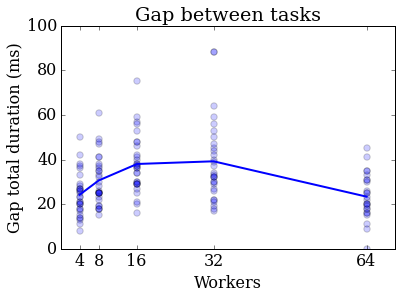

Worker idle time is not significant.

In [27]:
# Calculate total gap time in each execution and means

def calc_worker_gaps(tasks):
    gaps = 0
    for prev, nxt in zip(tasks, tasks[1:]):
        if nxt.start > prev.end:
            gap = nxt.start - prev.end
            gaps += gap
            #print('Gap of {:d}ms found between indices {:d} and {:d}'.format(gap, prev.index, nxt.index))
    return gaps

def calc_total_gaps(app):
    stage = app.stages[1]
    tasks = sorted([t for t in stage.tasks], key=lambda t: t.start)
    tasks = sorted(tasks, key=lambda t: t.host)
    app_gaps = 0
    for host in set((t.host for t in tasks)):
        host_tasks = [t for t in tasks if t.host == host]
        thr_tasks = [[host_tasks[0]], [host_tasks[1]]]
        for task in host_tasks[2:]:
            min(*thr_tasks, key=lambda ts: ts[-1].end).append(task)
        app_gaps += sum([calc_worker_gaps(tasks) for tasks in thr_tasks])
    return app_gaps

means = []
for workers in worker_amounts:
    _apps = (a for a in apps if a.workers == workers)
    total_gaps = [calc_total_gaps(a) for a in _apps]
    plt.scatter([workers] * len(total_gaps), total_gaps, alpha=0.2, s=40)
    means.append(np.mean(total_gaps))
plt.plot(worker_amounts, means)

plt.title('Gap between tasks')
plt_setup('Workers', 'Gap total duration (ms)')
plt.xticks([2**w for w in range(2, 7)])
plt.show()

Markdown(
    'Worker idle time is not significant.'
)

In [28]:
%%javascript // extension to hide code cells

//IPython.load_extensions('usability/codefolding/main');

<IPython.core.display.Javascript object>